In [1]:
import json
from pathlib import Path
from pprint import pprint
import pandas as pd
from datetime import timedelta
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def sharpe_ratio(s: pd.Series, n: int) -> pd.Series:
    denom = min(n, len(s))
    ann = 365 / denom
    s = s.loc[s.abs().gt(0)]
    s_mean = s.ewm(n).mean()
    s_std = s.ewm(n).std()
    return s_mean * ann / (s_std * np.sqrt(ann))

def sortino_ratio(s: pd.Series, n: int) -> pd.Series:
    denom = min(n, len(s))
    ann = 365 / denom
    s_mean = s.loc[s.abs().gt(0)].ewm(n).mean()
    s_std = s.loc[s.lt(0)].ewm(n).std()
    return s_mean * ann / (s_std * np.sqrt(ann))

def ross_ratio(s: pd.Series, weight: float, n: int) -> pd.Series:
    """
    similar to sortino but rather than excluding upward variance altogether, upward variance is downweighted by a specified factor.
    the problem with the sortino ratio is that it requires a decent number of periods with negative returns before a score can be calculated
    
    calculation:
    first the mean is calculated on all non-zero values of the series
    then the positive values are all scaled down by the weighting factor
    then the standard deviation is calculated on the modfied series
    lastly the ratio of mean / std is returned
    """
    denom = min(n, len(s))
    ann = 365 / denom
    s = s.loc[s.abs().gt(0)]
    s_mean = s.rolling(n).mean()
    s = s.where(s < 0, s * weight)
    s_std = s.rolling(n).std()
    
    return (s_mean * ann / (s_std * np.sqrt(ann)))

def ross_ratio_score(s: pd.Series, weight: float, n: int, granularity: int) -> pd.Series:
    """returns """
    rc_ratio = ross_ratio(s, weight, n)
    
    return (rc_ratio.pct_change()  # transform absolute values into relative values (relative to previous)
    .loc[rc_ratio.abs().gt(0)]  # remove any periods where there was no change from previous
    .gt(0)  # transform positive values into 1 and negative values into 0
    .rolling(granularity).sum()) / granularity  # return how many of the last x periods were up as a proportion of 1

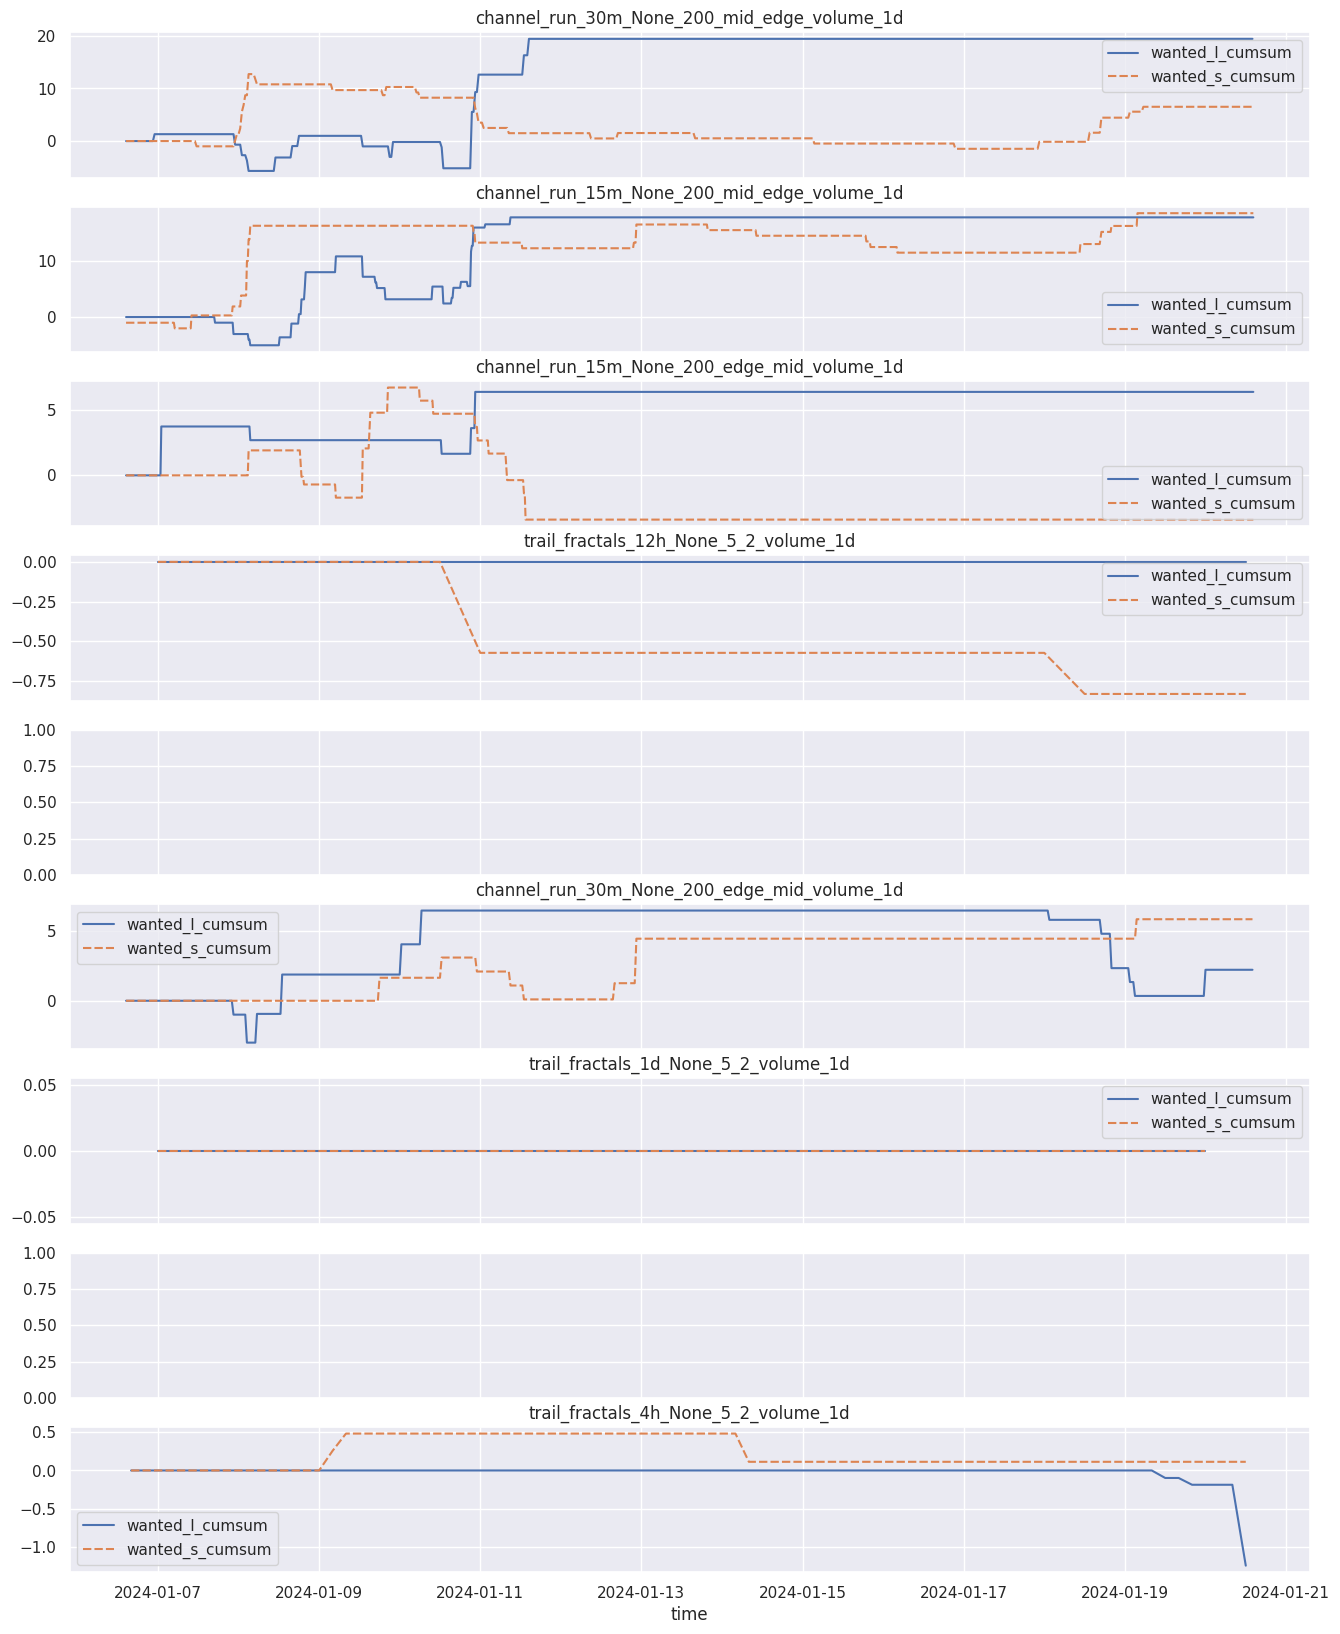

In [5]:
folder = Path("/home/ross/coding/modular_trader/records")
# for sub in folder.glob('*'):
#     print(sub.parts[-1])

sns.set(rc={"figure.figsize":(16, 20)}) #width=8, height=4
fig, axes = plt.subplots(len(list(folder.glob('*'))), 1, sharex=True)
data_sets = dict()
for i, agent in enumerate(folder.glob('*')):
    log_path = Path(f"{agent}/perf_log.json")
    if not log_path.exists():
        continue
    with open(log_path, 'r') as file:
        # print(log_path)
        try:
            perf_log = json.load(file)
        except json.JSONDecodeError:
            continue
    # print(f"Perf log contains {len(perf_log)} observations")

    perf_stats = [{'time': d['timestamp'],
                   # 'wanted_l': d['wanted_rpnl_long'],
                   # 'wanted_s': d['wanted_rpnl_short'],
                   # 'bal': d['balance'],
                   'wanted_l': d['real_rpnl_long'],
                   # 'sim_l': d['sim_rpnl_long'],
                   # 'unwanted_l': d['unwanted_rpnl_long'],
                   'wanted_s': d['real_rpnl_short'],
                   # 'sim_s': d['sim_rpnl_short'],
                   # 'unwanted_s': d['unwanted_rpnl_short'],
                   # 'real_tor': d.get('real_open_risk', 0),
                   # 'wanted_tor': d.get('wanted_open_risk', 0),
                   # 'positions': d.get('num_wanted_pos', 6),
                   # 'perf_score_ml_l': d.get('perf_score_ml_l', 0),
                   # 'perf_score_ml_s': d.get('perf_score_ml_s', 0),
                   } for d in perf_log]


    perf_df = pd.DataFrame(perf_stats)
    
    # organise dataframe
    perf_df['time'] = pd.to_datetime(perf_df.time, format='%d/%m/%y %H:%M')
    perf_df = perf_df.set_index('time', drop=True)
    df = perf_df.sort_index()
    df = df.fillna(0)
    
    # create cumulative columns
    n = 30
    df['wanted_l_sharpe'] = sharpe_ratio(df.wanted_l, n)
    df['wanted_s_sharpe'] = sharpe_ratio(df.wanted_s, n)
    df['wanted_l_sortino'] = sortino_ratio(df.wanted_l, n)
    df['wanted_s_sortino'] = sortino_ratio(df.wanted_s, n)
    df['wanted_l_ross'] = ross_ratio(df.wanted_l, 0.01, n)
    df['wanted_s_ross'] = ross_ratio(df.wanted_s, 0.01, n)
    
    perf_score_l = ross_ratio_score(df.wanted_l, 0.01, n, 10)
    df['perf_score_l'] = perf_score_l
    perf_score_s = ross_ratio_score(df.wanted_s, 0.01, n, 10)
    df['perf_score_s'] = perf_score_s
    
    df = df.ffill()
    # print(df.tail(10))
    
    # trim to window
    lookback = (df.index[-1] - timedelta(weeks=2))
    df = df.loc[df.index > lookback]
    
    df['wanted_l_cumsum'] = df.wanted_l.cumsum()
    df['wanted_s_cumsum'] = df.wanted_s.cumsum()
    
    df['perf_score_l'] = df.perf_score_l * df.wanted_l_cumsum.abs().max()
    df['perf_score_s'] = df.perf_score_s * df.wanted_s_cumsum.abs().max()

    # df['adj_open_risk'] = df.wanted_tor - df.positions
    # df['total_wanted_pnl'] = df.real + df.sim_wanted + df.adj_open_risk

    # df = df[['real', 'sim_wanted', 'unwanted', ]]
    # df = df[['total_wanted_pnl', 'wanted_tor', 'positions',]]
    df = df[[
        'wanted_l_cumsum', 'wanted_s_cumsum', 
        # 'wanted_l_sharpe', 'wanted_s_sharpe', 
        # 'wanted_l_ross',# 'wanted_s_sortino',
        # 'perf_score_l', 'perf_score_s'
    ]]
    
    # t = f"{agent.parts[-1]} Wanted Long: {df.wanted_l_sortino.iloc[-1]:.1f}, Wanted Short: {df.wanted_s_sortino.iloc[-1]:.1f}"
    t = f"{agent.parts[-1]}"
    sns.lineplot(data=df, ax=axes[i]).set(title=t)
    # sns.move_legend(loc='center left')
    # plt.legend()

# plt.savefig('/home/ross/coding/modular_trader/mt/inspect_records/perf_plot.jpg')
plt.show()